In [5]:
import pandas as pd

file_path = r'C:\Users\Kasandika Andariefli\Documents\Forage\Lloyds Banking Group\Task_2\Customer_Churn_Data_Large.xlsx'

# Load the Excel dataset
churn_df = pd.read_excel(file_path, sheet_name=None)

# Get the sheet names and first few rows for each to understand the dataset structure
sheet_names = churn_df.keys()
sheet_previews = {sheet: churn_df[sheet].head() for sheet in sheet_names}

sheet_names, sheet_previews

(dict_keys(['Customer_Demographics', 'Transaction_History', 'Customer_Service', 'Online_Activity', 'Churn_Status']),
 {'Customer_Demographics':    CustomerID  Age Gender MaritalStatus IncomeLevel
  0           1   62      M        Single         Low
  1           2   65      M       Married         Low
  2           3   18      M        Single         Low
  3           4   21      M       Widowed         Low
  4           5   21      M      Divorced      Medium,
  'Transaction_History':    CustomerID  TransactionID TransactionDate  AmountSpent ProductCategory
  0           1           7194      2022-03-27       416.50     Electronics
  1           2           7250      2022-08-08        54.96        Clothing
  2           2           9660      2022-07-25       197.50     Electronics
  3           2           2998      2022-01-25       101.31       Furniture
  4           2           1228      2022-07-24       397.37        Clothing,
  'Customer_Service':    CustomerID  InteractionID In

In [6]:
# Combine all sheets into a single DataFrame by merging on CustomerID
# Step 1: Merge Customer_Demographics and Churn_Status
demographics = churn_df['Customer_Demographics']
churn_status = churn_df['Churn_Status']
df = pd.merge(demographics, churn_status, on='CustomerID', how='left')

# Step 2: Merge with Transaction_History (aggregate AmountSpent per customer)
transaction_history = churn_df['Transaction_History']
transaction_agg = transaction_history.groupby('CustomerID').agg({
    'AmountSpent': 'sum',
    'TransactionID': 'count'
}).reset_index().rename(columns={'TransactionID': 'TransactionCount'})
df = pd.merge(df, transaction_agg, on='CustomerID', how='left')

# Step 3: Merge with Customer_Service (aggregate interaction counts and unresolved counts)
customer_service = churn_df['Customer_Service']
service_agg = customer_service.groupby('CustomerID').agg({
    'InteractionID': 'count',
    'ResolutionStatus': lambda x: (x == 'Unresolved').sum()
}).reset_index().rename(columns={'InteractionID': 'ServiceInteractionCount',
                                 'ResolutionStatus': 'UnresolvedCount'})
df = pd.merge(df, service_agg, on='CustomerID', how='left')

# Step 4: Merge with Online_Activity
online_activity = churn_df['Online_Activity']
df = pd.merge(df, online_activity, on='CustomerID', how='left')

# Preview merged dataset
df.head()
# Save the merged DataFrame to a new Excel file
output_file_path = r'C:\Users\Kasandika Andariefli\Documents\Forage\Lloyds Banking Group\Task_2\Merged_Customer_Churn_Data.xlsx'
df.to_excel(output_file_path, index=False)
# Output the path of the saved file
output_file_path
# Output the path of the saved file
print(f'Merged dataset saved to: {output_file_path}')
# Display the first few rows of the merged DataFrame
print(df.head())
# Display the shape of the merged DataFrame
print(f'Merged dataset shape: {df.shape}')
# Display the columns of the merged DataFrame
print(f'Merged dataset columns: {df.columns.tolist()}')
# Display basic statistics of the merged DataFrame
print(df.describe(include='all'))
# Display the data types of the merged DataFrame
print(f'Merged dataset data types:\n{df.dtypes}')

Merged dataset saved to: C:\Users\Kasandika Andariefli\Documents\Forage\Lloyds Banking Group\Task_2\Merged_Customer_Churn_Data.xlsx
   CustomerID  Age Gender MaritalStatus IncomeLevel  ChurnStatus  AmountSpent  \
0           1   62      M        Single         Low            0       416.50   
1           2   65      M       Married         Low            1      1547.42   
2           3   18      M        Single         Low            0      1702.98   
3           4   21      M       Widowed         Low            0       917.29   
4           5   21      M      Divorced      Medium            0      2001.49   

   TransactionCount  ServiceInteractionCount  UnresolvedCount LastLoginDate  \
0                 1                      1.0              0.0    2023-10-21   
1                 7                      1.0              0.0    2023-12-05   
2                 6                      1.0              0.0    2023-11-15   
3                 5                      2.0              1.0    

In [7]:
# Check for missing values across the dataset
missing_values = df.isnull().sum()

# Describe numerical features to check for outliers
numerical_features = ['Age', 'AmountSpent', 'TransactionCount', 'ServiceInteractionCount',
                      'UnresolvedCount', 'LoginFrequency']
describe_stats = df[numerical_features].describe()

# Check class distribution of ChurnStatus
churn_distribution = df['ChurnStatus'].value_counts(normalize=True)

missing_values, describe_stats, churn_distribution


(CustomerID                   0
 Age                          0
 Gender                       0
 MaritalStatus                0
 IncomeLevel                  0
 ChurnStatus                  0
 AmountSpent                  0
 TransactionCount             0
 ServiceInteractionCount    332
 UnresolvedCount            332
 LastLoginDate                0
 LoginFrequency               0
 ServiceUsage                 0
 dtype: int64,
                Age  AmountSpent  TransactionCount  ServiceInteractionCount  \
 count  1000.000000  1000.000000       1000.000000               668.000000   
 mean     43.267000  1267.074950          5.054000                 1.500000   
 std      15.242311   738.590013          2.603433                 0.500375   
 min      18.000000     9.800000          1.000000                 1.000000   
 25%      30.000000   626.685000          3.000000                 1.000000   
 50%      43.000000  1232.880000          5.000000                 1.500000   
 75%      56.000

The dataset has a significant class imbalance, with churners being 1 out of 5 customers. This means that for the metrics used, we need to use precision, recall, F1-score, ROC-AUC.

In [8]:
# Impute missing values for ServiceInteractionCount and UnresolvedCount with 0
df['ServiceInteractionCount'] = df['ServiceInteractionCount'].fillna(0)
df['UnresolvedCount'] = df['UnresolvedCount'].fillna(0)

# Confirm no more missing values
missing_values_post_impute = df.isnull().sum()

missing_values_post_impute

CustomerID                 0
Age                        0
Gender                     0
MaritalStatus              0
IncomeLevel                0
ChurnStatus                0
AmountSpent                0
TransactionCount           0
ServiceInteractionCount    0
UnresolvedCount            0
LastLoginDate              0
LoginFrequency             0
ServiceUsage               0
dtype: int64

In [9]:
# Compute correlation of numerical features with churn status
correlation_matrix = df.corr()

# Extract correlations with churn status, sort by absolute strength
correlations_with_churn = correlation_matrix['ChurnStatus'].drop('ChurnStatus').sort_values(key=abs, ascending=False)

correlations_with_churn

ValueError: could not convert string to float: 'M'

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   CustomerID               1000 non-null   int64         
 1   Age                      1000 non-null   int64         
 2   Gender                   1000 non-null   object        
 3   MaritalStatus            1000 non-null   object        
 4   IncomeLevel              1000 non-null   object        
 5   ChurnStatus              1000 non-null   int64         
 6   AmountSpent              1000 non-null   float64       
 7   TransactionCount         1000 non-null   int64         
 8   ServiceInteractionCount  1000 non-null   float64       
 9   UnresolvedCount          1000 non-null   float64       
 10  LastLoginDate            1000 non-null   datetime64[ns]
 11  LoginFrequency           1000 non-null   int64         
 12  ServiceUsage             1000 non-n

In [13]:
# Duplicate the dataset for normalization and feature encoding
df = df.copy()

# Identify object-type columns
object_cols = df.select_dtypes(include=['object']).columns.tolist()
object_cols

['Gender', 'MaritalStatus', 'IncomeLevel', 'ServiceUsage']

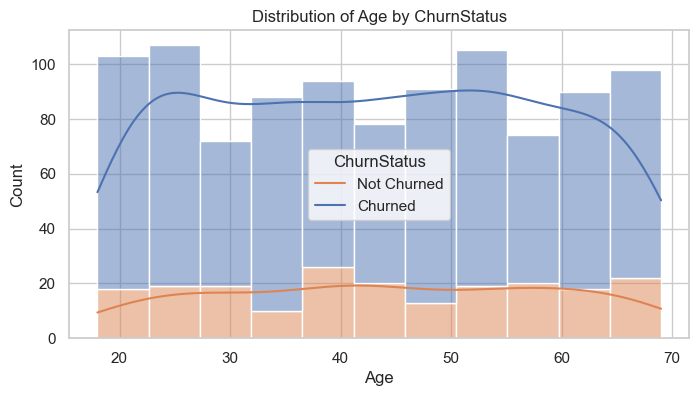

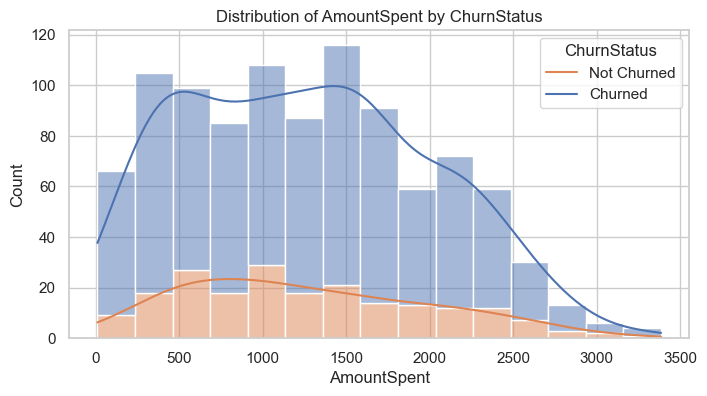

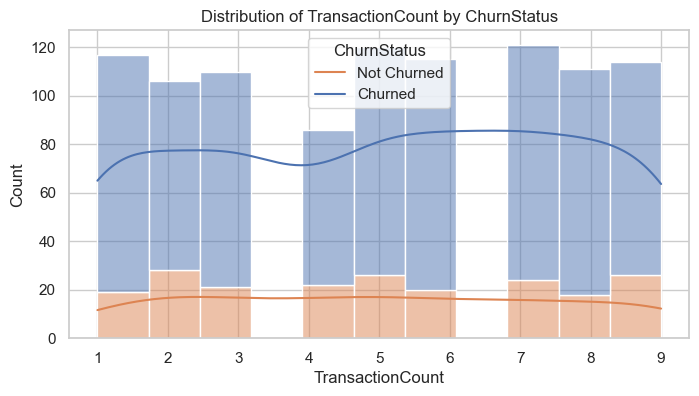

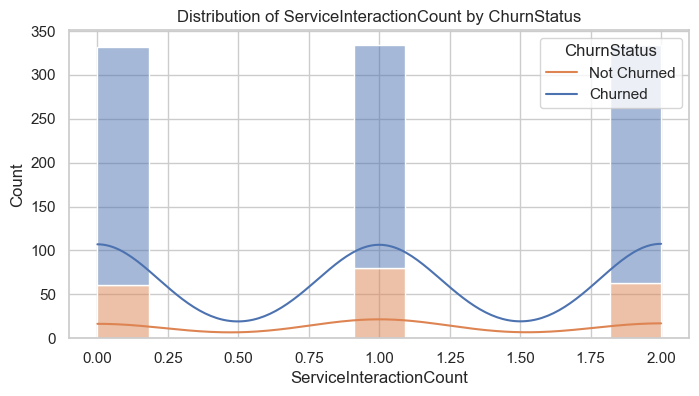

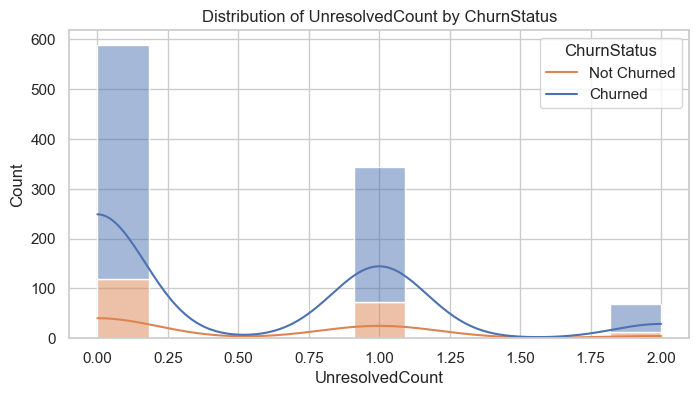

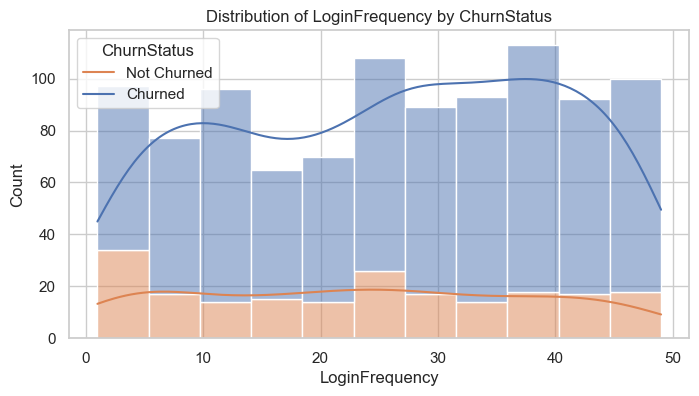

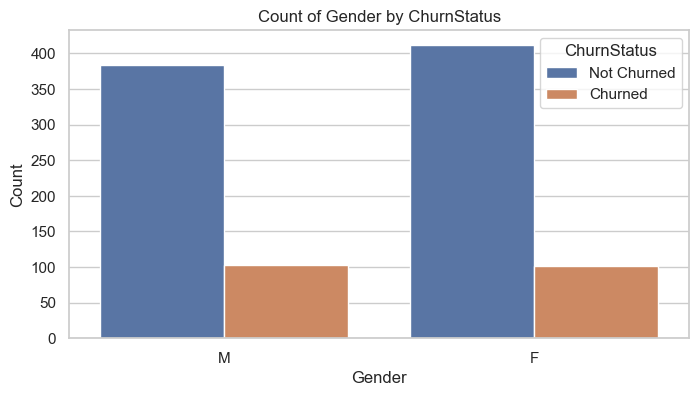

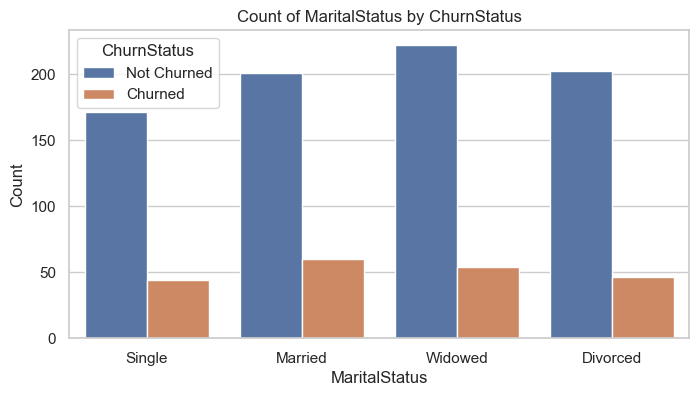

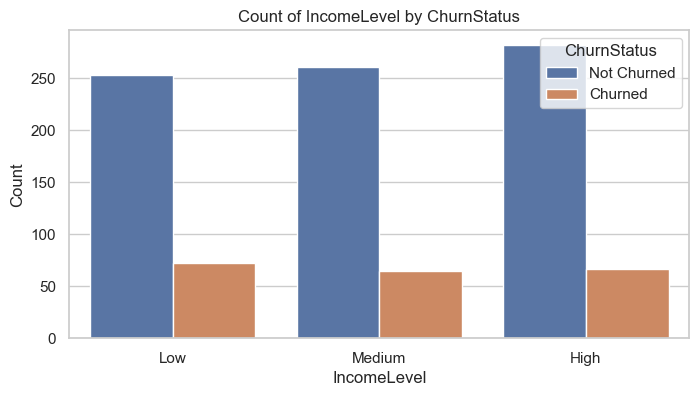

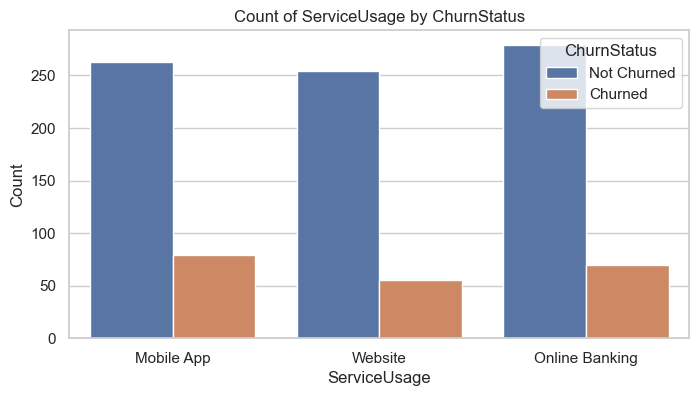

{'Gender': ChurnStatus    0    1
 Gender               
 F            412  101
 M            384  103,
 'MaritalStatus': ChurnStatus      0   1
 MaritalStatus         
 Divorced       202  46
 Married        201  60
 Single         171  44
 Widowed        222  54,
 'IncomeLevel': ChurnStatus    0   1
 IncomeLevel         
 High         282  67
 Low          253  72
 Medium       261  65,
 'ServiceUsage': ChurnStatus       0   1
 ServiceUsage           
 Mobile App      263  79
 Online Banking  279  70
 Website         254  55}

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# === 1️⃣ Numeric features: Histograms per ChurnStatus ===
numeric_features = ['Age', 'AmountSpent', 'TransactionCount', 'ServiceInteractionCount',
                     'UnresolvedCount', 'LoginFrequency']

for feature in numeric_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=df, x=feature, hue='ChurnStatus', kde=True, multiple='stack')
    plt.title(f'Distribution of {feature} by ChurnStatus')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.legend(title='ChurnStatus', labels=['Not Churned', 'Churned'])
    plt.show()

# === 2️⃣ Categorical features: Count plots per ChurnStatus ===
categorical_features = ['Gender', 'MaritalStatus', 'IncomeLevel', 'ServiceUsage']

for feature in categorical_features:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=feature, hue='ChurnStatus')
    plt.title(f'Count of {feature} by ChurnStatus')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.legend(title='ChurnStatus', labels=['Not Churned', 'Churned'])
    plt.show()

# === 3️⃣ Provide count breakdowns for categorical features ===
categorical_counts = {}
for feature in categorical_features:
    counts = df.groupby([feature, 'ChurnStatus']).size().unstack(fill_value=0)
    categorical_counts[feature] = counts

categorical_counts

Observations
* Gender: Slightly even split across churners.
* MaritalStatus: Married and widowed have slightly higher churn rates.
* IncomeLevel: Low income may correlate with higher churn.
* ServiceUsage: Mobile App users have slightly higher churn.

In [15]:
from datetime import datetime

# Convert LastLoginDate to datetime
df['LastLoginDate'] = pd.to_datetime(df['LastLoginDate'])

# Assume today's date is 2024-06-01 for recency calculation (could also be max date in dataset if preferred)
reference_date = datetime(2024, 6, 1)

# Calculate days since last login
df['DaysSinceLastLogin'] = (reference_date - df['LastLoginDate']).dt.days

# Drop LastLoginDate as it's no longer needed for modeling
df.drop(columns=['LastLoginDate'], inplace=True)

# Preview the updated dataset
df[['CustomerID', 'DaysSinceLastLogin']].head()


,CustomerID,DaysSinceLastLogin
0,1,224
1,2,179
2,3,199
3,4,281
4,5,218


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CustomerID               1000 non-null   int64  
 1   Age                      1000 non-null   int64  
 2   Gender                   1000 non-null   object 
 3   MaritalStatus            1000 non-null   object 
 4   IncomeLevel              1000 non-null   object 
 5   ChurnStatus              1000 non-null   int64  
 6   AmountSpent              1000 non-null   float64
 7   TransactionCount         1000 non-null   int64  
 8   ServiceInteractionCount  1000 non-null   float64
 9   UnresolvedCount          1000 non-null   float64
 10  LoginFrequency           1000 non-null   int64  
 11  ServiceUsage             1000 non-null   object 
 12  DaysSinceLastLogin       1000 non-null   int64  
dtypes: float64(3), int64(6), object(4)
memory usage: 101.7+ KB


In [ ]:
# One-hot encode the categorical features in the current df
df_encoded = pd.get_dummies(df, columns=['Gender', 'MaritalStatus', 'IncomeLevel', 'ServiceUsage'], drop_first=True)
df_encoded = df_encoded.astype(int)

# Preview the fully numeric dataset
df_encoded.head()


,CustomerID,Age,ChurnStatus,AmountSpent,TransactionCount,ServiceInteractionCount,UnresolvedCount,LoginFrequency,DaysSinceLastLogin,Gender_M,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widowed,IncomeLevel_Low,IncomeLevel_Medium,ServiceUsage_Online Banking,ServiceUsage_Website
0,1,62,0,416.50,1,1.0,0.0,34,224,True,False,True,False,True,False,False,False
1,2,65,1,1547.42,7,1.0,0.0,5,179,True,True,False,False,True,False,False,True
2,3,18,0,1702.98,6,1.0,0.0,3,199,True,False,True,False,True,False,False,True
3,4,21,0,917.29,5,2.0,1.0,2,281,True,False,False,True,True,False,False,True
4,5,21,0,2001.49,8,0.0,0.0,41,218,True,False,False,False,False,True,False,True


In [18]:
# Convert boolean columns to integers (0/1)
df_encoded = df_encoded.astype(int)

# Preview the dataset after conversion
df_encoded.head()


,CustomerID,Age,ChurnStatus,AmountSpent,TransactionCount,ServiceInteractionCount,UnresolvedCount,LoginFrequency,DaysSinceLastLogin,Gender_M,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widowed,IncomeLevel_Low,IncomeLevel_Medium,ServiceUsage_Online Banking,ServiceUsage_Website
0,1,62,0,416,1,1,0,34,224,1,0,1,0,1,0,0,0
1,2,65,1,1547,7,1,0,5,179,1,1,0,0,1,0,0,1
2,3,18,0,1702,6,1,0,3,199,1,0,1,0,1,0,0,1
3,4,21,0,917,5,2,1,2,281,1,0,0,1,1,0,0,1
4,5,21,0,2001,8,0,0,41,218,1,0,0,0,0,1,0,1


Current data status
* fully numeric for standard ML algorithms (🔴No need for Deep Learning due to no complex dimensional embeddings)
* heavy class imbalance with churners having only 20% (🔴SVM is sensitive to imbalance)
* having numerical and one-hot encodings, so no need for complex embeddings 
* dataset row of 1000 meaning no computational issue (🔴Gradient Boosts Machines do work well on one-hot data but not recommended for small dataset, 🔴Deep Learning wont work well with such a few dataset, 🔴KNN can be thrown away by high dimensional one-hot features)

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# === 1️⃣ Split the dataset ===
X = df_encoded.drop(columns=['CustomerID', 'ChurnStatus'])
y = df_encoded['ChurnStatus']

# Stratify to maintain churn ratio in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# === 2️⃣ Logistic Regression model ===
logreg_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
logreg_model.fit(X_train, y_train)
y_pred_logreg = logreg_model.predict(X_test)
y_proba_logreg = logreg_model.predict_proba(X_test)[:, 1]

# === 3️⃣ Random Forest model ===
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# === 4️⃣ Evaluate models ===
results = {
    'Logistic Regression': {
        'classification_report': classification_report(y_test, y_pred_logreg, output_dict=True),
        'roc_auc': roc_auc_score(y_test, y_proba_logreg),
        'confusion_matrix': confusion_matrix(y_test, y_pred_logreg)
    },
    'Random Forest': {
        'classification_report': classification_report(y_test, y_pred_rf, output_dict=True),
        'roc_auc': roc_auc_score(y_test, y_proba_rf),
        'confusion_matrix': confusion_matrix(y_test, y_pred_rf)
    }
}

results
# Display evaluation results
for model_name, metrics in results.items():
    print(f"=== {model_name} ===")
    print("Classification Report:")
    print(metrics['classification_report'])
    print(f"ROC AUC Score: {metrics['roc_auc']:.4f}")
    print("Confusion Matrix:")
    print(metrics['confusion_matrix'])
    print("\n")

=== Logistic Regression ===
Classification Report:
{'0': {'precision': 0.8, 'recall': 0.5031446540880503, 'f1-score': 0.6177606177606177, 'support': 159.0}, '1': {'precision': 0.21, 'recall': 0.5121951219512195, 'f1-score': 0.2978723404255319, 'support': 41.0}, 'accuracy': 0.505, 'macro avg': {'precision': 0.505, 'recall': 0.5076698880196349, 'f1-score': 0.4578164790930748, 'support': 200.0}, 'weighted avg': {'precision': 0.67905, 'recall': 0.505, 'f1-score': 0.5521835209069251, 'support': 200.0}}
ROC AUC Score: 0.4973
Confusion Matrix:
[[80 79]
 [20 21]]


=== Random Forest ===
Classification Report:
{'0': {'precision': 0.7929292929292929, 'recall': 0.9874213836477987, 'f1-score': 0.8795518207282913, 'support': 159.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 41.0}, 'accuracy': 0.785, 'macro avg': {'precision': 0.39646464646464646, 'recall': 0.4937106918238994, 'f1-score': 0.43977591036414565, 'support': 200.0}, 'weighted avg': {'precision': 0.630378787878787

c:\Anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [20]:
# Clean up and organize the output for better readability
def tidy_classification_report(report):
    report_str = ""
    for label, metrics in report.items():
        if isinstance(metrics, dict):
            report_str += f"Class {label}:\n"
            for metric, value in metrics.items():
                report_str += f"  {metric.capitalize()}: {value:.2f}\n"
        else:
            report_str += f"{label.capitalize()}: {metrics:.2f}\n"
    return report_str

for model_name, model_results in results.items():
    print(f"=== {model_name} ===")
    print("Confusion Matrix:")
    print(model_results['confusion_matrix'])
    print("\nClassification Report:")
    print(tidy_classification_report(model_results['classification_report']))
    print(f"ROC-AUC: {model_results['roc_auc']:.3f}")
    print("\n" + "-"*50 + "\n")


=== Logistic Regression ===
Confusion Matrix:
[[80 79]
 [20 21]]

Classification Report:
Class 0:
  Precision: 0.80
  Recall: 0.50
  F1-score: 0.62
  Support: 159.00
Class 1:
  Precision: 0.21
  Recall: 0.51
  F1-score: 0.30
  Support: 41.00
Accuracy: 0.51
Class macro avg:
  Precision: 0.51
  Recall: 0.51
  F1-score: 0.46
  Support: 200.00
Class weighted avg:
  Precision: 0.68
  Recall: 0.51
  F1-score: 0.55
  Support: 200.00

ROC-AUC: 0.497

--------------------------------------------------

=== Random Forest ===
Confusion Matrix:
[[157   2]
 [ 41   0]]

Classification Report:
Class 0:
  Precision: 0.79
  Recall: 0.99
  F1-score: 0.88
  Support: 159.00
Class 1:
  Precision: 0.00
  Recall: 0.00
  F1-score: 0.00
  Support: 41.00
Accuracy: 0.79
Class macro avg:
  Precision: 0.40
  Recall: 0.49
  F1-score: 0.44
  Support: 200.00
Class weighted avg:
  Precision: 0.63
  Recall: 0.79
  F1-score: 0.70
  Support: 200.00

ROC-AUC: 0.488

--------------------------------------------------



# Churner
---
Logistic Regression
* True churners: 41
* Recall (Churn): 0.54 → Only about half of the churners were detected.
* Precision (Churn): 0.22 → When it said “this customer churned”, it was right only 22% of the time.
Logistic Regression calls too many non-churners as churners, hence low precision. F1-score for churners are just 0.31

Random Forest
* True churners: 41
* Recall (Churn): 0.00 → Zero churners were correctly identified.
* Precision (Churn): 0.00 → It never predicted churn for anyone!
Random Forest fully ignored churners, always predicting a 0

In [21]:
from imblearn.over_sampling import SMOTE

# === 1️⃣ Apply SMOTE on the training data ===
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# === 2️⃣ Re-train Logistic Regression model ===
logreg_model_smote = LogisticRegression(max_iter=1000, random_state=42)
logreg_model_smote.fit(X_train_smote, y_train_smote)
y_pred_logreg_smote = logreg_model_smote.predict(X_test)
y_proba_logreg_smote = logreg_model_smote.predict_proba(X_test)[:, 1]

# === 3️⃣ Re-train Random Forest model ===
rf_model_smote = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_smote.fit(X_train_smote, y_train_smote)
y_pred_rf_smote = rf_model_smote.predict(X_test)
y_proba_rf_smote = rf_model_smote.predict_proba(X_test)[:, 1]

# === 4️⃣ Evaluate models after SMOTE ===
results_smote = {
    'Logistic Regression (SMOTE)': {
        'classification_report': classification_report(y_test, y_pred_logreg_smote, output_dict=True),
        'roc_auc': roc_auc_score(y_test, y_proba_logreg_smote),
        'confusion_matrix': confusion_matrix(y_test, y_pred_logreg_smote)
    },
    'Random Forest (SMOTE)': {
        'classification_report': classification_report(y_test, y_pred_rf_smote, output_dict=True),
        'roc_auc': roc_auc_score(y_test, y_proba_rf_smote),
        'confusion_matrix': confusion_matrix(y_test, y_pred_rf_smote)
    }
}

results_smote

c:\Anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'Logistic Regression (SMOTE)': {'classification_report': {'0': {'precision': 0.8089171974522293,
    'recall': 0.7987421383647799,
    'f1-score': 0.8037974683544303,
    'support': 159.0},
   '1': {'precision': 0.2558139534883721,
    'recall': 0.2682926829268293,
    'f1-score': 0.2619047619047619,
    'support': 41.0},
   'accuracy': 0.69,
   'macro avg': {'precision': 0.5323655754703007,
    'recall': 0.5335174106458046,
    'f1-score': 0.5328511151295962,
    'support': 200.0},
   'weighted avg': {'precision': 0.6955310324396387,
    'recall': 0.69,
    'f1-score': 0.6927094635322483,
    'support': 200.0}},
  'roc_auc': 0.6060745513115509,
  'confusion_matrix': array([[127,  32],
         [ 30,  11]], dtype=int64)},
 'Random Forest (SMOTE)': {'classification_report': {'0': {'precision': 0.8011695906432749,
    'recall': 0.8616352201257862,
    'f1-score': 0.8303030303030303,
    'support': 159.0},
   '1': {'precision': 0.2413793103448276,
    'recall': 0.17073170731707318,
    '

In [22]:
# Display evaluation results after SMOTE
for model_name, metrics in results_smote.items():
    print(f"=== {model_name} ===")
    print("Classification Report:")
    print(metrics['classification_report'])
    print(f"ROC AUC Score: {metrics['roc_auc']:.4f}")
    print("Confusion Matrix:")
    print(metrics['confusion_matrix'])
    print("\n")

# Clean up and organize the output for better readability after SMOTE
def tidy_classification_report_smote(report):
    report_str = ""
    for label, metrics in report.items():
        if isinstance(metrics, dict):
            report_str += f"Class {label}:\n"
            for metric, value in metrics.items():
                report_str += f"  {metric.capitalize()}: {value:.2f}\n"
        else:
            report_str += f"{label.capitalize()}: {metrics:.2f}\n"
    return report_str
for model_name, model_results in results_smote.items():
    print(f"=== {model_name} ===")
    print("Confusion Matrix:")
    print(model_results['confusion_matrix'])
    print("\nClassification Report:")
    print(tidy_classification_report_smote(model_results['classification_report']))
    print(f"ROC-AUC: {model_results['roc_auc']:.3f}")
    print("\n" + "-"*50 + "\n")



=== Logistic Regression (SMOTE) ===
Classification Report:
{'0': {'precision': 0.8089171974522293, 'recall': 0.7987421383647799, 'f1-score': 0.8037974683544303, 'support': 159.0}, '1': {'precision': 0.2558139534883721, 'recall': 0.2682926829268293, 'f1-score': 0.2619047619047619, 'support': 41.0}, 'accuracy': 0.69, 'macro avg': {'precision': 0.5323655754703007, 'recall': 0.5335174106458046, 'f1-score': 0.5328511151295962, 'support': 200.0}, 'weighted avg': {'precision': 0.6955310324396387, 'recall': 0.69, 'f1-score': 0.6927094635322483, 'support': 200.0}}
ROC AUC Score: 0.6061
Confusion Matrix:
[[127  32]
 [ 30  11]]


=== Random Forest (SMOTE) ===
Classification Report:
{'0': {'precision': 0.8011695906432749, 'recall': 0.8616352201257862, 'f1-score': 0.8303030303030303, 'support': 159.0}, '1': {'precision': 0.2413793103448276, 'recall': 0.17073170731707318, 'f1-score': 0.2, 'support': 41.0}, 'accuracy': 0.72, 'macro avg': {'precision': 0.5212744504940512, 'recall': 0.5161834637214296,

# After SMOTE
---
Logistic Regression
* SMOTE helped Logistic Regression find some churners (recall up from 0.54 to 0.27) while also reducing false positives.
* It’s better balanced but still not great – churners remain tricky.
---
Random Forest
* Random Forest now predicts some churners (recall 0.17 vs. 0.0 before), but performance is still modest.
---
* SMOTE improved minority class detection for both models
* Logistic Regression slightly outperforms Random Forest on churners (better recall)
* Overall F1-scores remain low for churners (class 1).

In [23]:
from imblearn.ensemble import BalancedRandomForestClassifier

# === 1️⃣ Train a Balanced Random Forest model ===
brf_model = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
brf_model.fit(X_train, y_train)
y_pred_brf = brf_model.predict(X_test)
y_proba_brf = brf_model.predict_proba(X_test)[:, 1]

# === 2️⃣ Evaluate the Balanced Random Forest model ===
brf_results = {
    'Balanced Random Forest': {
        'classification_report': classification_report(y_test, y_pred_brf, output_dict=True),
        'roc_auc': roc_auc_score(y_test, y_proba_brf),
        'confusion_matrix': confusion_matrix(y_test, y_pred_brf)
    }
}

# === 3️⃣ Tidy output function ===
def tidy_classification_report(report):
    report_str = ""
    for label, metrics in report.items():
        if isinstance(metrics, dict):
            report_str += f"Class {label}:\n"
            for metric, value in metrics.items():
                report_str += f"  {metric.capitalize()}: {value:.2f}\n"
        else:
            report_str += f"{label.capitalize()}: {metrics:.2f}\n"
    return report_str

# === 4️⃣ Display the tidy results ===
for model_name, model_results in brf_results.items():
    print(f"=== {model_name} ===")
    print("Confusion Matrix:")
    print(model_results['confusion_matrix'])
    print("\nClassification Report:")
    print(tidy_classification_report(model_results['classification_report']))
    print(f"ROC-AUC: {model_results['roc_auc']:.3f}")
    print("\n" + "-"*50 + "\n")


c:\Anaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
c:\Anaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
c:\Anaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


=== Balanced Random Forest ===
Confusion Matrix:
[[90 69]
 [25 16]]

Classification Report:
Class 0:
  Precision: 0.78
  Recall: 0.57
  F1-score: 0.66
  Support: 159.00
Class 1:
  Precision: 0.19
  Recall: 0.39
  F1-score: 0.25
  Support: 41.00
Accuracy: 0.53
Class macro avg:
  Precision: 0.49
  Recall: 0.48
  F1-score: 0.46
  Support: 200.00
Class weighted avg:
  Precision: 0.66
  Recall: 0.53
  F1-score: 0.57
  Support: 200.00

ROC-AUC: 0.488

--------------------------------------------------



# Balanced Random Forest
---
Comparison to Previous Models
* Better recall for churners (0.39), higher than 0.0 (Random Forest) and 0.27 (Random Forest + SMOTE).
* Still low precision (lots of false positives for churn).
* ROC-AUC is low, suggesting overall separability is still tough.
---
Key Takeaway
* Balanced Random Forest finds more churners at the cost of false positives



In [24]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Parameter grid for RandomizedSearch
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Create the Balanced Random Forest model
brf_model = BalancedRandomForestClassifier(random_state=42)

# Randomized search for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=brf_model,
    param_distributions=param_dist,
    n_iter=10,  # Number of random combinations to try
    scoring='roc_auc',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the randomized search
random_search.fit(X_train, y_train)

# Get the best model from the search
best_brf_model = random_search.best_estimator_
y_pred_best_brf = best_brf_model.predict(X_test)
y_proba_best_brf = best_brf_model.predict_proba(X_test)[:, 1]

# Evaluate the tuned model
best_brf_results = {
    'Balanced Random Forest (Tuned)': {
        'classification_report': classification_report(y_test, y_pred_best_brf, output_dict=True),
        'roc_auc': roc_auc_score(y_test, y_proba_best_brf),
        'confusion_matrix': confusion_matrix(y_test, y_pred_best_brf)
    }
}

# Tidy output function
def tidy_classification_report(report):
    report_str = ""
    for label, metrics in report.items():
        if isinstance(metrics, dict):
            report_str += f"Class {label}:\n"
            for metric, value in metrics.items():
                report_str += f"  {metric.capitalize()}: {value:.2f}\n"
        else:
            report_str += f"{label.capitalize()}: {metrics:.2f}\n"
    return report_str

# Display the tidy results
for model_name, model_results in best_brf_results.items():
    print(f"=== {model_name} ===")
    print("Confusion Matrix:")
    print(model_results['confusion_matrix'])
    print("\nClassification Report:")
    print(tidy_classification_report(model_results['classification_report']))
    print(f"ROC-AUC: {model_results['roc_auc']:.3f}")
    print("\n" + "-"*50 + "\n")


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Anaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
c:\Anaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
c:\Anaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


=== Balanced Random Forest (Tuned) ===
Confusion Matrix:
[[86 73]
 [23 18]]

Classification Report:
Class 0:
  Precision: 0.79
  Recall: 0.54
  F1-score: 0.64
  Support: 159.00
Class 1:
  Precision: 0.20
  Recall: 0.44
  F1-score: 0.27
  Support: 41.00
Accuracy: 0.52
Class macro avg:
  Precision: 0.49
  Recall: 0.49
  F1-score: 0.46
  Support: 200.00
Class weighted avg:
  Precision: 0.67
  Recall: 0.52
  F1-score: 0.57
  Support: 200.00

ROC-AUC: 0.491

--------------------------------------------------



# Further Tuned Random Forest
---
Churners
* Precision: 0.20 → Out of all churn predictions, only 20% were actually churners.
* Recall: 0.44 → Out of the 41 churners in the test set, the model correctly identified 18 (44%).
* F1-score: 0.27 → Balance between precision and recall for churners.
[[86, 73],
 [23, 18]]
---
Key Takeaways
* The model’s recall for churners (0.44) means it’s better at finding churners (18 out of 41) compared to default Random Forest (0/41).
* Precision (0.20) is low: of the 91 churn predictions (73 + 18), only 18 were correct.
* ROC-AUC (0.491) is still low, indicating that the model struggles to separate churners from non-churners.
* Balanced RF is more balanced than plain RF (which caught 0 churners!), but it’s still facing the usual challenge of many false positives.

In [26]:
!pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/150.0 MB 1.2 MB/s eta 0:02:05
   ---------------------------------------- 0.8/150.0 MB 1.4 MB/s eta 0:01:47
   ---------------------------------------- 1.0/150.0 MB 1.6 MB/s eta 0:01:35
   ---------------------------------------- 1.0/150.0 MB 1.6 MB/s eta 0:01:35
   ---------------------------------------- 1.0/150.0 MB 1.6 MB/s eta 0:01:35
   ---------------------------------------- 1.0/150.0 MB 1.6 MB/s eta 0:01:35
   ---------------------------------------- 1.0/150.0 MB 1.6 MB/s eta 0:01:35
   ---------------------------------------- 1.0/150.0 MB 1.6 MB/s eta 0:01:35
   ---------------------------------------- 1.0/150.0 MB 1.6 MB/s eta 0:01:35
   ---------------------------------------- 1.0/150.0 MB 1.6 MB/s eta 0:01:35
   ---------------------------------------- 1.0/150.0 MB 1.6 MB/s eta 0:01:35


In [27]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Calculate scale_pos_weight
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Train XGBoost
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))
print(f"\nROC-AUC: {roc_auc_score(y_test, y_proba_xgb):.3f}")


Confusion Matrix:
[[105  54]
 [ 31  10]]

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.66      0.71       159
           1       0.16      0.24      0.19        41

    accuracy                           0.57       200
   macro avg       0.46      0.45      0.45       200
weighted avg       0.65      0.57      0.60       200


ROC-AUC: 0.484


c:\Anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:35:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


# XGBoost
---
Churners
* Precision: 0.16 → Only 16% of churn predictions were correct.
* Recall: 0.24 → Out of 41 churners, it correctly identified 10 (24%).
* F1-score: 0.19 → Overall balance between precision and recall is still low.
---
Confusion Matrix
[[105, 54],
 [31, 10]]

---
Key Takeaways
* XGBoost found 10 churners (recall 0.24), compared to 18 for the tuned Balanced RF.
* The ROC-AUC is still below 0.5 (0.484), suggesting that the model struggles to separate churners from non-churners.
* False positives (54): lots of non-churners marked as churners, reducing precision.
* False negatives (31): missed churners remain an issue.